In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


from input_generator import load_dataset, load_dataset_with_lables
from data_parser import *
from df import create_seperate_columns, create_listed_columns

In [2]:
# Get dataframe with tags and category_id columns
csvpath = '/content/CAvideos.csv'
tab_dataframe = load_tags_and_labels_df(csvpath)
max_of_tags = 15

vocab = get_vocab(tab_dataframe['tags'])
tab_dataframe = create_seperate_columns(tab_dataframe, max_of_tags, 'tags')

tab_dataframe.head()

,category_id,tags0,tags1,tags2,tags3,tags4,tags5,tags6,tags7,tags8,tags9,tags10,tags11,tags12,tags13,tags14
0,10,Eminem,Walk,On,Water,Aftermath/Shady/Interscope,Rap,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,23,plush,bad unboxing,unboxing,fan mail,idubbbztv,idubbbztv2,things,best,packages,plushies,chontent chop,notags,notags,notags,notags
2,23,racist superman,rudy,mancuso,king,bach,racist,superman,love,rudy mancuso poo bear black white official mus...,iphone x by pineapple,lelepons,hannahstocking,rudymancuso,inanna,anwar
3,24,ryan,higa,higatv,nigahiga,i dare you,idy,rhpc,dares,no truth,comments,comedy,funny,stupid,fail,notags
4,10,edsheeran,ed sheeran,acoustic,live,cover,official,remix,official video,lyrics,session,notags,notags,notags,notags,notags


In [3]:
# Convert vocab to dictionary
voc_di = {i: vo for i, vo in enumerate(vocab)}
voc_di[0] = 'notags'
voc_di = {vo: i for i, vo in voc_di.items()}

# Mapping tags to indexes in vocab
for index in range(0, max_of_tags):
    tab_dataframe['tags{}'.format(index)] = tab_dataframe['tags{}'.format(index)].map(voc_di)

tab_dataframe.fillna(0.0, inplace = True) 
tab_dataframe.head()

,category_id,tags0,tags1,tags2,tags3,tags4,tags5,tags6,tags7,tags8,tags9,tags10,tags11,tags12,tags13,tags14
0,10,144996,23915.0,34900,80986.0,134279,78163,0,0.0,0,0.0,0,0,0,0,0
1,23,119219,87588.0,5207,109839.0,93912,109886,51520,30826.0,108579,8988.0,90347,0,0,0,0
2,23,64946,16131.0,3691,126309.0,134967,139464,84459,128244.0,28619,145403.0,61545,42511,36980,67977,146765
3,24,52104,142009.0,145068,110166.0,81581,47326,129135,140900.0,141166,134043.0,103978,37755,53060,81126,0
4,10,141065,43411.0,142149,139546.0,11786,125200,134798,81147.0,1812,149556.0,0,0,0,0,0


In [0]:
future_df = []
col_row_dict = {}
# We only use 1/4 of the dataset!
first_half_df = tab_dataframe[:10000]

In [0]:
for i in range(0, 10000):
    for col in first_half_df.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':first_half_df[col][i]})
        else:
            col_row_dict.update({'tag{}'.format(first_half_df[col][i]):1.0})
    future_df.append(col_row_dict)
    col_row_dict = {}

In [6]:
final_dataframe = pd.DataFrame(future_df)
final_dataframe.fillna(0.0, inplace = True)
final_dataframe.head()

,category_id,tag0,tag0.0,tag1,tag100004,tag100007.0,tag10001.0,tag100011,tag100013.0,tag100015,tag100017,tag100025,tag100031,tag100035,tag100037.0,tag100038,tag100038.0,tag100040,tag100045.0,tag100047.0,tag100049,tag100055,tag100066,tag100067,tag100076,tag100076.0,tag100077,tag100078,tag100083,tag100087,tag100090,tag100091,tag100103,tag100104.0,tag100110,tag100111,tag100112,tag100117.0,tag100122,tag100122.0,...,tag99780,tag99785,tag99786,tag99790,tag99791.0,tag99793,tag99798,tag99806,tag99811,tag99818,tag99819.0,tag99820,tag99820.0,tag99821,tag99826,tag99830.0,tag99836,tag99836.0,tag99840,tag99852,tag99880,tag99882,tag99883,tag99917,tag99917.0,tag99918,tag99926,tag99927,tag99931,tag99941,tag99943,tag99946,tag99965,tag99969,tag9997.0,tag99973,tag99974,tag99974.0,tag99978.0,tag99997
0,10,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Create train,validation and test examples from dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = load_dataset_with_lables(final_dataframe, 'category_id')

In [8]:
hidden = 64
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(2*hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(44, activation='softmax')])

model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=5,
                    validation_data=(val_ds, val_lb))


W0813 11:55:59.220242 139909791922048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 14s 2ms/sample - loss: 1.9539 - acc: 0.5336 - val_loss: 1.0786 - val_acc: 0.7856
Epoch 2/5
6400/6400 [==============================] - 13s 2ms/sample - loss: 0.7265 - acc: 0.8966 - val_loss: 0.8540 - val_acc: 0.8444
Epoch 3/5
6400/6400 [==============================] - 13s 2ms/sample - loss: 0.5200 - acc: 0.9463 - val_loss: 0.7880 - val_acc: 0.8512
Epoch 4/5
6400/6400 [==============================] - 13s 2ms/sample - loss: 0.4703 - acc: 0.9508 - val_loss: 0.7773 - val_acc: 0.8469
Epoch 5/5
6400/6400 [==============================] - 13s 2ms/sample - loss: 0.4519 - acc: 0.9516 - val_loss: 0.7759 - val_acc: 0.8438


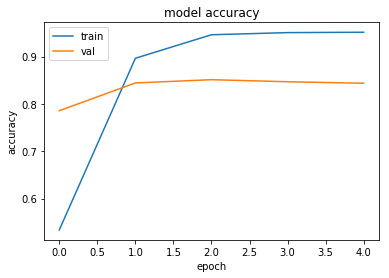

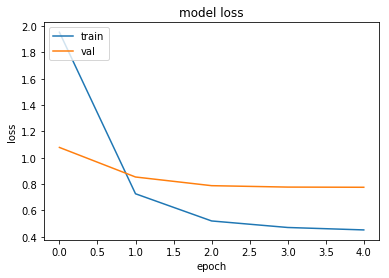

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict[loss'']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
results = model.evaluate(test_ds, test_lb)

print(results)

2000/2000 [==============================] - 1s 719us/sample - loss: 0.8179 - acc: 0.8475
[0.8178716907501221, 0.8475]
